# Understanding Attention and Chat GPT

### Goal is to implement decoder block of transfromer from the paper "Attention is all you need " to make a GPT for shakespeare text 

# Resources Used 
1.   Andrej Karpathy excellent implementation lectures: https://www.youtube.com/watch?v=kCc8FmEb1nY
2.   CMU lectures on Deep Learning: https://deeplearning.cs.cmu.edu/S23/index.html



## Getting the data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!python -m wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

/usr/bin/python3: No module named wget


In [ ]:
## reading entire file into a string, text
with open(r'input.txt','r',encoding='utf-8') as f:
    text=f.read()

In [ ]:
## Have a look at first 200 chacaters
print(text[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Total number of unique characters in our file
chars=sorted(list(set(text)))
vocab_size=len(chars)
print("".join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


## Tokenization
### Converting a sequence of characters into a sequence of integers

In [ ]:
stoi={s:i for (i,s) in enumerate(chars)}  ## character to integers
itos={i:s for (s,i) in stoi.items()}      ## integers to characters
encode= lambda s: [stoi[c] for c in s]   ## takes a string as input and outputs a list of integers
decode= lambda i : "".join([itos[j] for j in i]) ## takes a list of integers and outputs a string of characters


In [ ]:
e=encode('Himanshu')
d=decode(e)
d=='Himanshu'

True

In [ ]:
## Encoding the entire piece of text that we have 
import torch
data=torch.tensor(encode(text),dtype=torch.long)
print(data.shape)

torch.Size([1115394])


In [ ]:
print(len(text))   ## we have one integer for every character in the string

1115394


In [ ]:
## Splitting into training and validation data
n=int(0.9*len(data))
train_data=data[:n]
val_data=data[n:]

In [ ]:
torch.manual_seed(1337)
batch_size=4 ## how many training examples will be seen/ computed on during the training
block_size=8 ## determines the maximum length of the context that the tranformers will see during training

def get_batch(split):
    data=train_data if split =='train' else val_data
    ix=torch.randint(len(data)-block_size,(batch_size,)) ## gives the index for first character, randomly sampled
    x=torch.stack([data[i:i+block_size] for i in ix])
    y=torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x,y

In [ ]:
xb,yb=get_batch('train')

## Baseline model: A simple bigram model

In [ ]:
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)                 ## for reproducibility 

class Bigram(nn.Module):
    def __init__(self,vocab_size):
        super().__init__()
        self.token_embedding_table=nn.Embedding(vocab_size,vocab_size)
        
    def forward(self,idx,targets=None):
        logits=self.token_embedding_table(idx) ## (Batch=4,Time=8,Channel=vocab_size=65)
        if targets==None:
            loss=None
        ## Converting the dimensions in the way pytorch cross,entropy function expects
        else:
            B,T,C=logits.shape

            #print(B,T,C)
            logits=logits.view(B*T,C)
            targets=targets.view(B*T)

            loss=F.cross_entropy(logits,targets)

        return logits,loss
    
    
    ## A function to generate samples
    def generate(self,idx,max_new_tokens):
        for _ in range(max_new_tokens):
            logits,loss=self(idx)
            
            ## focusing only on the last step as the last token will be responsible for generating next token
            logits=logits[:,-1,:] ## b,C
            
            probs=F.softmax(logits,dim=-1) ## (B,C)
            
            idx_next=torch.multinomial(probs,num_samples=1)  ##(B,1)
            
            idx=torch.cat((idx,idx_next),dim=1) ##(B,T+1)
            
        return idx

model=Bigram(vocab_size)
logits,loss=model(xb,yb)

print(logits.shape)
print(loss)

torch.Size([256, 65])
tensor(4.7125, grad_fn=<NllLossBackward0>)


In [ ]:
## Generating from the totally random model without training
print(decode(model.generate(idx=torch.zeros((1,1),dtype=torch.long),max_new_tokens=100)[0].tolist()))


Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


#### As, we can see the generated output is totally garbage as it is the result of randomly generated embeddings for each character 

In [ ]:
## optimizer instance for training our model
optimizer=torch.optim.AdamW(model.parameters(),lr=1e-3)

In [ ]:
## training 
batch_size=32 ## increasing batch_size

for steps in range(10000):
    ## sampling a batch of data
    xb,yb=get_batch('train')

    ##evaluate loss and backpropogate the same 
    logits,loss=model(xb,yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.5727508068084717


In [ ]:
## Generate again after training 

print(decode(model.generate(idx=torch.zeros((1,1),dtype=torch.long),max_new_tokens=100)[0].tolist()))


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y helti


#### We can observe that after training a bigram NN model, we have a better generation but it is still not good as context lenght is only 1. We will now inspect if the situation can be improved using attention and ultimately transformers 


## Self-Attention 

### Each token(Embedding of every token) will generate a key,a query and a value through linear transformations. These keys and queries interact with each other to provide the dependence between them, which is further used in calculating the context vector using weighted average of values

In [ ]:
## Implementing a single head self attention block 

torch.manual_seed(1337)
B,T,C= 4,8,32

## Trying on a random matrix
x=torch.rand(B,T,C)


## A single head of head size 16
head_size=16
key=nn.Linear(C,head_size,bias=False)
query=nn.Linear(C,head_size,bias=False)
value=nn.Linear(C,head_size,bias=False)



k=key(x)  ## (B,T,16) , EACH EMBEDDING OF 32 DIMENSION IS CONVERTED INTO HEAD SIZE DIM THROUGH A LINEAR LAYER
q=query(x) ##(B,T,16)
v=value(x)

## calculating weights after dot product of keys and queries
wei=q@k.transpose(-2,-1)   ## (B,T,16) @(B,16,T)


## Masking the future tokens to propogate any information 
tril=torch.tril(torch.ones(T,T))

wei=wei.masked_fill(tril==0,float('-inf'))   ## Replaces value of every future token with -inf
                                            ## so that it does not contribute while normalizing using softmax
wei=F.softmax(wei,dim=1)
out=wei@v



In [ ]:
## Making a class for attention

class Head(nn.Module):
    def __init__(self,head_size):
        super().__init__()
        self.key=nn.Linear(n_emb,head_size,bias=False)
        self.query=nn.Linear(n_emb,head_size,bias=False)
        self.value=nn.Linear(n_emb,head_size,bias=False)
        
        ## As, tril is not a parameter, we assign it using register_buffer
        self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size)))
        
    
    def forward(self,x):
        
        B,T,C= x.shape
        
        k=key(x)  ## (B,T,C) , EACH EMBEDDING OF 32 DIMENSION IS CONVERTED INTO HEAD SIZE DIM THROUGH A LINEAR LAYER
        q=query(x) ##(B,T,C)
        v=value(x)

        ## calculating weights after dot product of keys and queries
        wei=q@k.transpose(-2,-1)   ## (B,T,16) @(B,16,T)


        ## Masking the future tokens to propogate any information 
        tril=torch.tril(torch.ones(T,T))

        wei=wei.masked_fill(tril==0,float('-inf'))   ## Replaces value of every future token with -inf
                                                    ## so that it does not contribute while normalizing using softmax
        wei=F.softmax(wei,dim=1)
        out=wei@v
        
        return out 
        

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [ ]:
a.shape

torch.Size([8, 8])

In [ ]:
b=torch.ones(B,T,C)

In [ ]:
b.shape

torch.Size([4, 8, 32])

In [ ]:
# conda install pytorch torchvision cudatoolkit=10.1 -c pytorch

In [ ]:
# torch.cuda.is_available()

## Building Mini GPT for our model(DECODER BLOCK OF TRANSFORMERS)

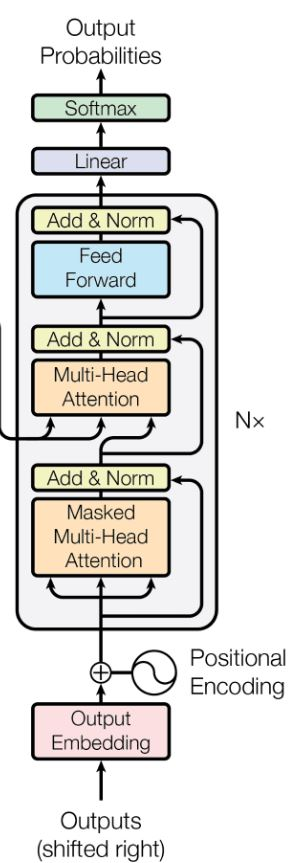

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F


# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------



In [ ]:
## Building single head for self attention 
class Head(nn.Module):
    def __init__(self,head_size):
        super().__init__()
        self.key=nn.Linear(n_embd,head_size,bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        
        ## We implement tril for masking the future tokens as a register_bufffer as it is not a model parameter
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
        
        
        
    def forward(self,x):
        B,T,C=x.shape   ## Batch,Time,Channel(number of heads) 
        k=self.key(x)
        q=self.query(x)
        v=self.value(x)
        
        ##computing attention score for each token across the batch
        
        wei=q@k.transpose(-2,-1)*C**-0.5   ## (B,T,C)@ (B,C,T)-> (B,T,T); Dividing by root of number of heads
        wei=wei.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        wei=F.softmax(wei,dim=-1) 
        wei=self.dropout(wei)
        
        
        ## Perform the wiegted aggregation on values
        out=wei@v  #(B,T,T)@(B,T,C)->(B,T,C)
        return out 
    
    
## Implementing multiHead Attention 
class MultiHeadAttention(nn.Module):
    
    def __init__(self,num_heads,head_size):
        super().__init__()
        
        ##ModuleList can be indexed like a regular Python list, but
        ## modules it contains are properly registered, and
        ##will be visible by all Module methods.
        self.heads=nn.ModuleList([Head(head_size) for i in range(num_heads)])
        self.proj=nn.Linear(n_embd,n_embd)
        self.dropout=nn.Dropout(dropout)
        
    def forward(self,x):
        out=torch.cat([h(x) for h in self.heads],dim=-1)
        out=self.dropout(self.proj(out))
        return out 
    

class Feedforward(nn.Module):
    
    def __init__(self,n_embd):
        super().__init__()
        self.net=nn.Sequential(
        nn.Linear(n_embd,4*n_embd),
        nn.ReLU(),
        nn.Linear(4*n_embd,n_embd),
        nn.Dropout(dropout)
        )
        
    def forward(self,x):
        return self.net(x)
    


In [ ]:
## Implementing a single transformer block 
class Block(nn.Module):
    def __init__(self,n_embd,n_head):
        super().__init__()
        head_size=n_embd//n_head
        
        ##Self attention :  Communication Layer
        self.sa = MultiHeadAttention(n_head,head_size)
        
        ## Feedforward layer : Computation Layer
        self.ffwd = Feedforward(n_embd)
        
        ## Layernorms
        
        self.ln1=nn.LayerNorm(n_embd)
        self.ln2=nn.LayerNorm(n_embd)
        
    def forward(self,x):
        x=x+self.sa(self.ln1(x))
        x=x+self.ffwd(self.ln2(x))
        return x
        

In [ ]:
## Implementing Attention Magic to our Bigram model
class GPTLanguageModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        
        self.token_embedding_table=nn.Embedding(vocab_size,n_embd)
        self.position_embedding_table=nn.Embedding(block_size,n_embd)
        self.blocks=nn.Sequential(*[Block(n_embd,n_head=n_head) for i in range(n_layer)])
        
        self.ln_f=nn.LayerNorm(n_embd)
        
        self.lm_head=nn.Linear(n_embd, vocab_size)
        
        
    def forward(self, idx, targets=None):
        
        B,T= idx.shape
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
            for i in range(max_new_tokens):
                # crop idx to the last block_size tokens
                idx_cond = idx[:, -block_size:]
                # get the predictions
                logits, loss = self(idx_cond)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            return idx

In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()



0.209729 M parameters
step 0: train loss 4.3348, val loss 4.3424
step 100: train loss 2.6633, val loss 2.6783
step 200: train loss 2.5182, val loss 2.5157
step 300: train loss 2.4254, val loss 2.4443
step 400: train loss 2.3804, val loss 2.3860
step 500: train loss 2.3229, val loss 2.3459
step 600: train loss 2.2716, val loss 2.2868
step 700: train loss 2.2249, val loss 2.2483
step 800: train loss 2.1918, val loss 2.2232
step 900: train loss 2.1455, val loss 2.1875
step 1000: train loss 2.1274, val loss 2.1637
step 1100: train loss 2.1076, val loss 2.1397
step 1200: train loss 2.0524, val loss 2.1051
step 1300: train loss 2.0382, val loss 2.1007
step 1400: train loss 2.0090, val loss 2.0714
step 1500: train loss 1.9926, val loss 2.0445
step 1600: train loss 1.9738, val loss 2.0305
step 1700: train loss 1.9594, val loss 2.0280
step 1800: train loss 1.9380, val loss 2.0208
step 1900: train loss 1.9221, val loss 2.0145
step 2000: train loss 1.9008, val loss 1.9941
step 2100: train loss 1.

In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))



WARD:
I know a live thit? hee, they here have fairs!
Not will pretted wish that you warst!
O a then, nor forner; scurph.

BUCKINGHARENCE:
Kild gone abely anchry, Mark-our will.

MONTAGUE:
Gues, well.

DUCES:
Well, so pulinerats that you sI contrangety, O I weak the amisterunty by must I am bawn it a
her stays of this. are is thou stide
For withan daling ancues.

DUKEDET:
Begal ese fall, any ame the bray dold?
O, fortuful a, I'yrul well.

POMSAREY:
'Tis bett guves; they fallow?

MERCUS:
Then, on 
